In [56]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from category_encoders import TargetEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv('../data/dados_tratados.csv')

df.head()

,year,circuitId,constructorId,driverId,grid,positionOrder,weather_category,raceId,alt,driver_race_count,driver_win_count,constructor_race_count,constructor_win_count,years_since_debut,recent_form
0,2009,1,1,1,18,20,Dry,1,10,35,9.0,35,9.0,2.0,12.321117
1,2009,2,1,1,12,7,Rain,2,18,36,9.0,36,9.0,2.0,20.000000
2,2009,17,1,1,9,6,Rain,3,5,47,11.0,47,11.0,2.0,13.500000
3,2009,3,1,1,5,4,Dry,4,7,37,9.0,37,9.0,2.0,11.000000
4,2009,4,1,1,14,9,Dry,5,109,38,9.0,38,9.0,2.0,5.666667


In [57]:
def calculate_competitiveness_knn(df, target_race_id, k):
    features_knn = ['circuitId', 'weather_category', 'alt', 'year']

    categorical_features = ['weather_category']
    numerical_features = ['alt', 'year']

    preprocessor_knn = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ],
        remainder='passthrough'
    )

    X_knn = df[features_knn]
    preprocessor_knn.fit(X_knn)
    X_knn_processed = preprocessor_knn.transform(X_knn)

    target_race_rows = df[df['raceId'] == target_race_id]
    if target_race_rows.empty:
        raise ValueError(f"raceId {target_race_id} não encontrado no DataFrame.")
    target_race_idx = target_race_rows.index[0]
    target_race_vector = X_knn_processed[target_race_idx].reshape(1, -1)

    knn = NearestNeighbors(n_neighbors=k+1)
    knn.fit(X_knn_processed)
    distances, indices = knn.kneighbors(target_race_vector)

    similar_indices = indices[0][1:]
    top_k_races = df.iloc[similar_indices]

    top5_counter = top_k_races[top_k_races['positionOrder'] <= 5]['driverId'].value_counts()

    drivers_target_race = df[df['raceId'] == target_race_id]['driverId']
    competitiveness = drivers_target_race.map(top5_counter).fillna(0)

    result = pd.Series(0, index=df.index, dtype=float)
    result.loc[drivers_target_race.index] = competitiveness

    return result

In [58]:
df['competitiveness_knn'] = 0.0

for race_id in df['raceId'].unique():
    comp = calculate_competitiveness_knn(df, race_id, k=20)
    df['competitiveness_knn'] += comp

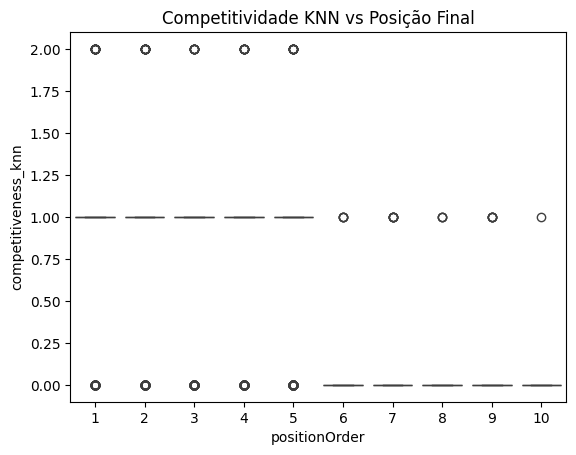

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df[df['positionOrder'] <= 10], x='positionOrder', y='competitiveness_knn')
plt.title('Competitividade KNN vs Posição Final')
plt.show()


In [60]:
df['competitiveness_knn'].unique()

array([0., 1., 2.])

In [61]:

categorical_onehot = ['weather_category']
categorical_target = ['constructorId', 'driverId']
numerical_cols = ['year', 'grid', 'driver_race_count', 'driver_win_count', 'constructor_race_count', 'constructor_win_count', 'years_since_debut', 'recent_form', 'competitiveness_knn']

X = df.drop(columns=['positionOrder'])
y = df['positionOrder']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

te = TargetEncoder(cols=categorical_target)
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()
X_train_enc[categorical_target] = te.fit_transform(X_train[categorical_target], y_train)
X_test_enc[categorical_target] = te.transform(X_test[categorical_target])

preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_onehot),
    ('num', StandardScaler(), numerical_cols)
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=42))
])

pipeline.fit(X_train_enc, y_train)
y_pred = pipeline.predict(X_test_enc)

print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1619
[LightGBM] [Info] Number of data points in the train set: 13899, number of used features: 19
[LightGBM] [Info] Start training from score 12.416936
R2: 0.5756556310345365
MAE: 3.5619025202543426
MSE: 21.70391141217988


c:\Users\arthu\.virtualenvs\PodiumAI-8XUIG6TA\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
